In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from scipy.linalg import expm


In [ ]:
def get_circ(input, param):
    q = QuantumRegister(1, 'q')
    c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(q, c)
    if input == 1:
        circ.x(q[0])
    circ.rx(param[0], q[0])
    circ.measure(q[0], c[0])
    return circ

def get_acierto(couts, label):
    # Return 1 if the label with the most counts matches the correct label, otherwise return 0
    if couts:
        max_label = max(couts, key=couts.get)
        if str(label) == max_label:
            return 1
    return 0



def get_coste(counts, label, shots):
    # Return 1 if the label is not present in counts
    if str(label) not in counts:
        return 1
    return (1 - counts[str(label)] / shots)

def get_fallo_total(df,backend,param,N_Shots):   
    fallo_total=0
    log=[]
    length = len(df)


    for i in range(length):
        qc=get_circ(df[i], param)
        if df[i] == 0:
            label = "1"
        else:
            label = "0"
        transpiled_circuit = transpile(qc, backend=backend, optimization_level=1)
        job = backend.run(transpiled_circuit, shots=N_Shots)
        result = job.result()
        counts = result.get_counts()
        fallo_total += get_coste(counts,label,N_Shots)
        log.append([label,counts,df[i]])
    
    return fallo_total/length, log


def SPSA(cost_fn, theta_0, a,b,A,s,t,gamma,M,train_set,backend,N_Shots=100):

    theta = theta_0.copy()
    thetas = []
    rendimietnos = []
    v_new = np.zeros(len(theta_0))
    v_old = np.zeros(len(theta_0))

    for k in range(0,int(M)):
        v_old = v_new.copy()

        alpha_k = a/(k+1+A)**s
        beta_k = b/(k+1)**t        
        delta = np.random.choice([-1, 1], size=len(theta))
        print(theta + alpha_k * delta)
        y_plus,_ = cost_fn(train_set ,backend, (theta + alpha_k * delta),N_Shots)
        y_minus,_ = cost_fn(train_set ,backend, (theta - alpha_k * delta),N_Shots)

        g_k = (y_plus - y_minus) / (2 * alpha_k)
        v_new = gamma*v_old - beta_k * g_k*delta
        theta += v_new
        thetas.append(theta.copy())
        rendimietno, log = cost_fn(train_set[0:4], backend, theta, N_Shots)
        rendimietno = 1 - rendimietno
        rendimietnos.append(rendimietno)
        print(f"Iteración {k}: Coste_mas = {y_plus}, Coste_menos = {y_minus}, gradiente = {g_k},rendimiento = {rendimietno},alpha = {alpha_k}, beta = {beta_k}")

    return theta, thetas, rendimietnos

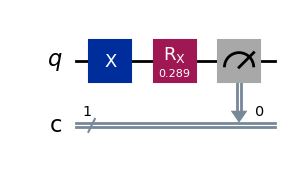

In [39]:
data=[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]
param=[np.random.uniform(0, 1)]
qc= get_circ(data[1], param)
backend = Aer.get_backend('qasm_simulator')
qc.draw('mpl')

In [40]:
N_shots = 1000
a=0.05
b=0.5
A=5
s=0.101
t=0.6
gamma=0.05
M = 100
fallo_inicial, log = get_fallo_total(data, backend, param, N_shots)
print(f"Fallo inicial: {fallo_inicial}")
new_theta, Thetalog, rendimentos= SPSA(get_fallo_total, param, a, b, A, s, t, gamma, M, data,backend, N_shots)

Fallo inicial: 0.980875
[-1]
[0.24723068]
Iteración 0: Coste_mas = 0.9851249999999999, Coste_menos = 0.9738125, gradiente = 0.135566339160642,rendimiento = 0.026000000000000023,alpha = 0.0417231153029624, beta = 0.5
[1]
[0.39781552]
Iteración 1: Coste_mas = 0.960875, Coste_menos = 0.9750624999999998, gradiente = -0.1726874500253852,rendimiento = 0.04700000000000004,alpha = 0.04107854970906752, beta = 0.3298769776932236
[1]
[0.45761999]
Iteración 2: Coste_mas = 0.9474999999999998, Coste_menos = 0.96575, gradiente = -0.2251515584902357,rendimiento = 0.051750000000000074,alpha = 0.04052825599426546, beta = 0.2586409289858933
[-1]
[0.4382939]
Iteración 3: Coste_mas = 0.9530624999999998, Coste_menos = 0.9356875000000002, gradiente = 0.2169218535422422,rendimiento = 0.07074999999999987,alpha = 0.04004898472946174, beta = 0.21763764082403106
[1]
[0.56824087]
Iteración 4: Coste_mas = 0.9194375, Coste_menos = 0.9423124999999999, gradiente = -0.28864304853761424,rendimiento = 0.08800000000000008

In [41]:
fallo, log = get_fallo_total(data, backend, new_theta, N_shots)
print(f"Fallo final: {fallo}")

Fallo final: 0.028125000000000025


(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(1.0))

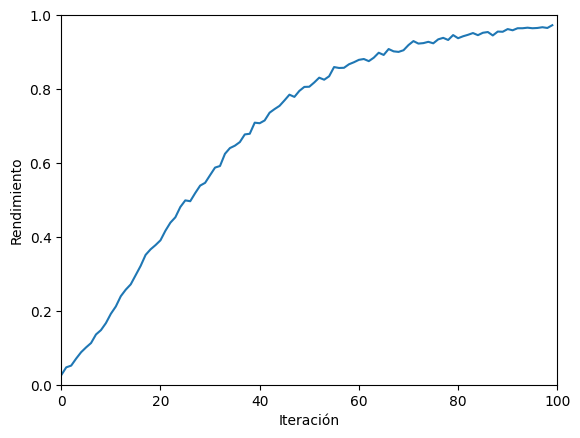

In [44]:
plt.plot(rendimentos)
plt.xlabel('Iteración')
plt.ylabel('Rendimiento')
plt.axis([0, 100, 0, 1])

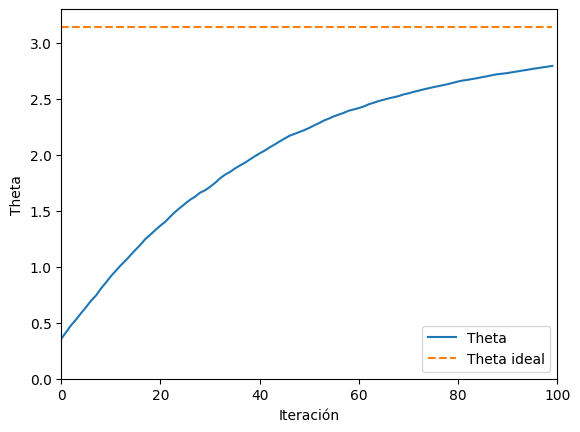

In [48]:
pi=np.ones(len(Thetalog))*np.pi
plt.plot(Thetalog, label='Theta')
plt.plot(pi, label='Theta ideal', linestyle='--')
plt.axis([0, 100, 0, np.pi*1.05])
plt.xlabel('Iteración')
plt.ylabel('Theta')
plt.legend()
plt.show()

In [ ]:
# Ejecutar el circuito para entrada 0
qc0 = get_circ(0, new_theta)
job0 = backend.run(transpile(qc0, backend=backend), shots=N_shots)
counts0 = job0.result().get_counts()

# Ejecutar el circuito para entrada 1
qc1 = get_circ(1, new_theta)
job1 = backend.run(transpile(qc1, backend=backend), shots=N_shots)
counts1 = job1.result().get_counts()


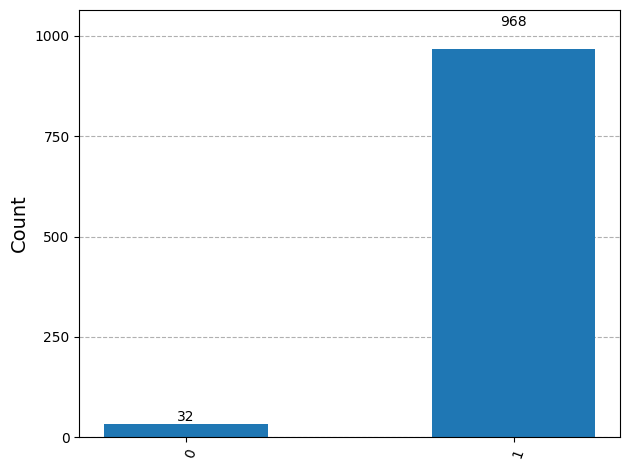

In [60]:
plot_histogram(counts0)

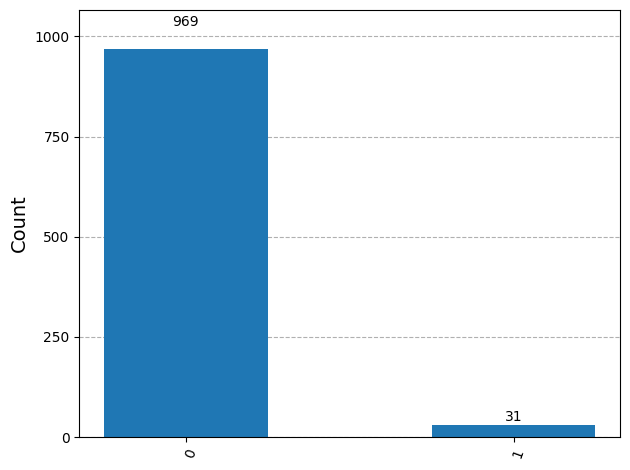

In [58]:
plot_histogram(counts1)